In [99]:
# import libraries
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
from sqlalchemy import create_engine
import pandas as pd
import datetime
import pymysql
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin


# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import torch.optim as optim

# for number-crunching
import numpy as np

import copy

In [10]:
user = "erpnext_sql"
password = "rtp[ps4XRF0_pX"
db = "_abde597b15b69fc8"
host = "erpnext.responsible-ai.net"
port = "3333"

In [11]:
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}")

# Data

In [5]:
data_sql_full = pd.read_sql("""
    Select 		
	po.name, 
        po.supplier, 
        po.total_qty,
        po.transaction_date as order_date,
        po_items.schedule_date,
        po_receipt.posting_date as delivered_date
    FROM `tabPurchase Order` po
    LEFT JOIN `tabPurchase Order Item` po_items
    	on po.name = po_items.parent
    LEFT JOIN `tabPurchase Receipt Item` po_receipt_item
    	on po.name = po_receipt_item.purchase_order 
    LEFT JOIN `tabPurchase Receipt` po_receipt
    	on po_receipt_item.parent = po_receipt.name
    """, engine)

In [14]:
data_sql_full.head()

,purchase_order_name,supplier,total_qty,order_date,schedule_date,delivered_date,set_warehouse,item_name,order_month,order_year,schedule_month,schedule_year
0,e,Beans Inc.,750.0,2020-06-14,None,None,Naples - RR,None,6,2020,NaN,NaN
1,PUR-ORD-2024-08-00002,Beans Inc.,750.0,2023-04-24,2023-04-29,2023-05-04,Naples - RR,Excelsa,4,2023,4.0,2023.0
2,PUR-ORD-2024-08-00003,Fair Trade AG,750.0,2024-09-08,2024-09-21,None,Nairobi - RR,Arabica,9,2024,9.0,2024.0
3,PUR-ORD-2024-08-00004,Aromatico,1000.0,2022-10-26,2022-11-10,2022-11-29,Amsterdam - RR,Maragogype,10,2022,11.0,2022.0
4,PUR-ORD-2024-08-00005,Aromatico,500.0,2022-03-18,2022-04-05,2022-04-24,London - RR,Maragogype Type B,3,2022,4.0,2022.0


In [17]:
# Get size of dataset
data_sql_full.shape

(17181, 12)

In [18]:
# Check datatypes
data_sql_full.dtypes

purchase_order_name     object
supplier                object
total_qty              float64
order_date              object
schedule_date           object
delivered_date          object
set_warehouse           object
item_name               object
order_month              int32
order_year               int32
schedule_month         float64
schedule_year          float64
dtype: object

In [37]:
# Drop nulls for key columns
data_sql_full.dropna(inplace=True, subset=["delivered_date", "schedule_date", "set_warehouse", "item_name"])

# Convert timestamps
data_sql_full["delivered_date"] = pd.to_datetime(data_sql_full["delivered_date"])
data_sql_full["schedule_date"] = pd.to_datetime(data_sql_full["schedule_date"])
data_sql_full["order_date"] = pd.to_datetime(data_sql_full["order_date"])

# Calculate if purchase order was late
data_sql_full["late"] = data_sql_full["delivered_date"] > data_sql_full["schedule_date"]

# Calculate days late
data_sql_full["days_late"] = (data_sql_full["delivered_date"] - data_sql_full["schedule_date"]).dt.days

# Check days late by supplier
days_late_by_supplier = data_sql_full.groupby('supplier')["days_late"].mean().sort_values(ascending=False)

# Add seasonality features (month and year)
data_sql_full["order_month"] = data_sql_full["order_date"].dt.month
data_sql_full["order_year"] = data_sql_full["order_date"].dt.year
data_sql_full["schedule_month"] = data_sql_full["schedule_date"].dt.month
data_sql_full["schedule_year"] = data_sql_full["schedule_date"].dt.year

# Create dummies for supplier
d_suppliers = pd.get_dummies(data_sql_full['supplier'], prefix="supplier")

# Create dummies for warehouse
d_warehouse = pd.get_dummies(data_sql_full['set_warehouse'], prefix="warehouse")

# Create dummies for item_name
d_items = pd.get_dummies(data_sql_full['item_name'], prefix="item")

# Concatenate all dummies into the dataset
data_for_model = pd.concat([data_sql_full, d_suppliers, d_warehouse, d_items], axis=1)

# Define the feature list
features = (
    ["total_qty", "order_month", "order_year", "schedule_month", "schedule_year"]
    + list(d_suppliers.columns)
    + list(d_warehouse.columns)
    + list(d_items.columns)
)

# Re-organize the data: train/test in DataLoaders

In [94]:
# Drop 'purchase_order_name' as it is not relevant for features
data_for_model = data_for_model.drop(columns=['purchase_order_name'], errors='ignore')

# Initial features list before encoding
initial_features = (
    ['total_qty'] +  # Retain numeric features
    [col for col in data_for_model.columns if col.startswith('d_')] +
    [col for col in data_for_model.columns if col.startswith('warehouse_')] +
    [col for col in data_for_model.columns if col.startswith('item_')]
)

# Convert split_date to a datetime object
split_date = datetime.datetime(2022, 9, 1)

# Perform the train/test split based on order_date
train = data_for_model[data_for_model["order_date"] <= split_date].copy()
test = data_for_model[data_for_model["order_date"] > split_date].copy()

# Ensure all features are numeric and handle NaNs
train[initial_features] = train[initial_features].fillna(0)
test[initial_features] = test[initial_features].fillna(0)

# Identify and encode non-numeric columns in the features list
non_numeric_columns = train.select_dtypes(include=['object', 'category']).columns
if len(non_numeric_columns) > 0:
    print(f"Encoding non-numeric columns: {non_numeric_columns}")

    # One-hot encode non-numeric columns
    train = pd.get_dummies(train, columns=non_numeric_columns, prefix=non_numeric_columns, drop_first=True)
    test = pd.get_dummies(test, columns=non_numeric_columns, prefix=non_numeric_columns, drop_first=True)

    # Align train and test columns after encoding (to ensure consistent feature sets)
    train, test = train.align(test, join='outer', axis=1, fill_value=0)

# Remove duplicate column names
train = train.loc[:, ~train.columns.duplicated()]
test = test.loc[:, ~test.columns.duplicated()]

# Dynamically update the features list to include new one-hot encoded columns, excluding unwanted features
features = [
    col for col in train.columns
    if col not in ['days_late', 'order_date', 'schedule_date', 'delivered_date',
                   'order_month', 'order_year', 'schedule_month', 'schedule_year', 'late']
]

# Verify alignment and ensure features list matches DataFrame columns
print(f"Features length: {len(features)}")
print(f"Train columns length: {train.shape[1]}")
print(f"Test columns length: {test.shape[1]}")

# Ensure all features are numeric and convert to float
train[features] = train[features].astype(float)
test[features] = test[features].astype(float)

# Ensure labels (target) are numeric
train['days_late'] = pd.to_numeric(train['days_late'], errors='coerce')
test['days_late'] = pd.to_numeric(test['days_late'], errors='coerce')

# Drop rows with NaNs in target or features
train = train.dropna(subset=['days_late'])
test = test.dropna(subset=['days_late'])

# Extract tensors for training and testing
train_dataT = torch.tensor(train[features].values).float()
train_labelT = torch.tensor(train['days_late'].values).float().view(-1, 1)

test_dataT = torch.tensor(test[features].values).float()
test_labelT = torch.tensor(test['days_late'].values).float().view(-1, 1)

# Confirm sizes
print(f'Original data: {data_for_model.shape}')
print(f'Train data: {train_dataT.shape}')
print(f'Train labels: {train_labelT.shape}')
print(f'Test data: {test_dataT.shape}')
print(f'Test labels: {test_labelT.shape}')


Encoding non-numeric columns: Index(['supplier', 'set_warehouse', 'item_name'], dtype='object')
Features length: 30
Train columns length: 39
Test columns length: 39
Original data: (15570, 31)
Train data: torch.Size([9195, 30])
Train labels: torch.Size([9195, 1])
Test data: torch.Size([6375, 30])
Test labels: torch.Size([6375, 1])


In [96]:
# Create PyTorch Dataset
train_data = TensorDataset(train_dataT, train_labelT)

# Define batch size
batchsize = 32

# Create DataLoader for training
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)

# Create DataLoader for testing
test_data = TensorDataset(test_dataT, test_labelT)
test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=False, drop_last=False)

# Verify DataLoader
for batch_features, batch_labels in train_loader:
    print(f"Batch features shape: {batch_features.shape}")
    print(f"Batch labels shape: {batch_labels.shape}")
    break


Batch features shape: torch.Size([32, 30])
Batch labels shape: torch.Size([32, 1])


# Standard model

In [131]:

# Define the neural network architecture
class ANNDaysLate(nn.Module):
    def __init__(self):
        super(ANNDaysLate, self).__init__()
        
        # Input layer
        self.input = nn.Linear(30, 80)
        
        # Hidden layers
        self.hidden1 = nn.Linear(80, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.hidden4 = nn.Linear(64, 32)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)
        self.dropout4 = nn.Dropout(0.1)
        
        # Output layer
        self.output = nn.Linear(32, 1)
    
    def forward(self, x):
        # if total_qty is 0, set days_late to 0
        total_qty = x[:, 0].view(-1, 1)
        x = F.relu(self.input(x))
        x = self.dropout1(x)
        x = F.relu(self.hidden1(x))
        x = self.dropout2(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout3(x)
        x = F.relu(self.hidden3(x))
        x = self.dropout4(x)
        x = F.relu(self.hidden4(x))
        x = self.output(x)  # No activation function for the output layer
        
        # Apply the rule to set days_late to 0 if total_qty is 0
        x = torch.where(total_qty == 0, torch.tensor(0.0, device=x.device), x)
        
        return x
      
# Instantiate the model
model = ANNDaysLate()
print(model)

ANNDaysLate(
  (input): Linear(in_features=30, out_features=80, bias=True)
  (hidden1): Linear(in_features=80, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=128, bias=True)
  (hidden3): Linear(in_features=128, out_features=64, bias=True)
  (hidden4): Linear(in_features=64, out_features=32, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
  (dropout4): Dropout(p=0.1, inplace=False)
  (output): Linear(in_features=32, out_features=1, bias=True)
)


In [132]:
# Instantiate the model
model = ANNDaysLate()

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
patience = 50  # Number of epochs to wait without improvement
best_loss = float('inf')  # Initialize the best loss as infinity
counter = 0  # Counter for epochs without improvement

# Placeholder for the best model state
best_model_state = None
model_file = "FINAL_best_model.pkl"  # File to save the best model

# Training loop
num_epochs = 2000
trainLoss = []
testLoss = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    
    # Training: Loop through batches
    for batch_features, batch_labels in train_loader:
        # Forward pass
        outputs = model(batch_features)
        loss = loss_function(outputs, batch_labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate training loss for this epoch
        epoch_train_loss += loss.item()
    
    # Average training loss for this epoch
    epoch_train_loss /= len(train_loader)
    trainLoss.append(epoch_train_loss)
    
    # Testing: Loop through batches
    model.eval()
    epoch_test_loss = 0.0
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            test_outputs = model(batch_features)
            loss = loss_function(test_outputs, batch_labels)
            epoch_test_loss += loss.item()
    
    # Average test loss for this epoch
    epoch_test_loss /= len(test_loader)
    testLoss.append(epoch_test_loss)
    
    # Early stopping logic and save the best model
    if epoch_test_loss < best_loss:
        best_loss = epoch_test_loss
        counter = 0  # Reset the counter if test loss improves
        
        # Save the best model's state_dict
        with open(model_file, "wb") as f:
            pickle.dump(model.state_dict(), f)
        print(f"Best model saved at epoch {epoch+1} with test loss: {best_loss:.4f}")
    else:
        counter += 1  # Increment the counter if no improvement
    
    # Check if early stopping condition is met
    if counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break
    
    # Print progress
    current_lr = optimizer.param_groups[0]['lr']
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, LR: {current_lr:.6f}')

# Final losses
print(f"Final Train Loss: {trainLoss[-1]:.4f}")
print(f"Final Test Loss: {testLoss[-1]:.4f}")
print(f"Best model saved as: {model_file}")


Best model saved at epoch 1 with test loss: 65.9378
Best model saved at epoch 2 with test loss: 21.8283
Best model saved at epoch 3 with test loss: 11.8561
Best model saved at epoch 5 with test loss: 9.2864
Best model saved at epoch 8 with test loss: 7.4701
Best model saved at epoch 10 with test loss: 7.3884
Epoch [10/2000], Train Loss: 9.3269, Test Loss: 7.3884, LR: 0.001000
Best model saved at epoch 13 with test loss: 6.5847
Best model saved at epoch 17 with test loss: 6.3733
Best model saved at epoch 19 with test loss: 5.9093
Epoch [20/2000], Train Loss: 7.4642, Test Loss: 6.0416, LR: 0.001000
Best model saved at epoch 23 with test loss: 5.8163
Best model saved at epoch 29 with test loss: 5.6228
Epoch [30/2000], Train Loss: 6.2883, Test Loss: 6.8634, LR: 0.001000
Epoch [40/2000], Train Loss: 5.8757, Test Loss: 5.8335, LR: 0.001000
Epoch [50/2000], Train Loss: 5.6518, Test Loss: 6.6921, LR: 0.001000
Epoch [60/2000], Train Loss: 5.8014, Test Loss: 6.8817, LR: 0.001000
Epoch [70/2000],

In [133]:
# Define functions for MAE, RMSE, and R2
def compute_mae(predictions, targets):
    return torch.mean(torch.abs(predictions - targets)).item()

def compute_rmse(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2)).item()

def compute_r2(predictions, targets):
    ss_total = torch.sum((targets - torch.mean(targets)) ** 2)
    ss_residual = torch.sum((targets - predictions) ** 2)
    return 1 - (ss_residual / ss_total).item()

# Evaluate on the test set
model.eval()  # Set the model to evaluation mode
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        predictions = model(batch_features)
        all_predictions.append(predictions)
        all_targets.append(batch_labels)

# Concatenate all predictions and targets
all_predictions = torch.cat(all_predictions)
all_targets = torch.cat(all_targets)

# Compute metrics
mae = compute_mae(all_predictions, all_targets)
rmse = compute_rmse(all_predictions, all_targets)
r2 = compute_r2(all_predictions, all_targets)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


MAE: 2.0731
RMSE: 2.6807
R²: 0.8070


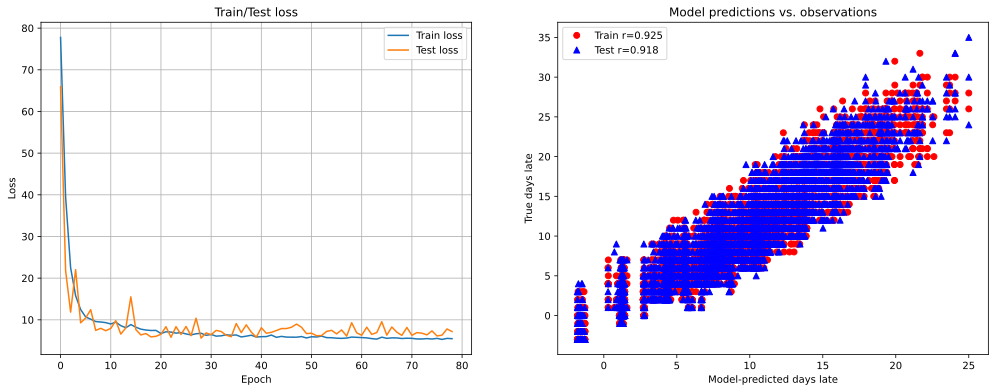

In [134]:
# Evaluate the model on the train and test sets
model.eval()
with torch.no_grad():
    yHatTrain = model(train_dataT)
    yHatTest = model(test_dataT)

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(17, 6))

# Plot train/test loss
ax[0].plot(trainLoss, label='Train loss')
ax[0].plot(testLoss, label='Test loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()

# Plot model predictions vs. observations
ax[1].plot(yHatTrain.detach(), train_labelT, 'ro', label='Train')
ax[1].plot(yHatTest.detach(), test_labelT, 'b^', label='Test')
ax[1].set_xlabel('Model-predicted days late')
ax[1].set_ylabel('True days late')
ax[1].set_title('Model predictions vs. observations')

# Correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().numpy().T, train_labelT.numpy().T)[1, 0]
corrTest = np.corrcoef(yHatTest.detach().numpy().T, test_labelT.numpy().T)[1, 0]
ax[1].legend([f'Train r={corrTrain:.3f}', f'Test r={corrTest:.3f}'])

plt.show()

In [135]:
features

['total_qty',
 'supplier_Aromatico',
 'supplier_Beans Inc.',
 'supplier_Fair Trade AG',
 'supplier_Farmers of Brazil',
 'supplier_Handelskontor Hamburg',
 'warehouse_Amsterdam - RR',
 'warehouse_Barcelona - RR',
 'warehouse_Hamburg - RR',
 'warehouse_Istanbul - RR',
 'warehouse_London - RR',
 'warehouse_Nairobi - RR',
 'warehouse_Naples - RR',
 'item_Arabica',
 'item_Excelsa',
 'item_Liberica',
 'item_Maragogype',
 'item_Maragogype Type B',
 'item_Robusta',
 'set_warehouse_Barcelona - RR',
 'set_warehouse_Hamburg - RR',
 'set_warehouse_Istanbul - RR',
 'set_warehouse_London - RR',
 'set_warehouse_Nairobi - RR',
 'set_warehouse_Naples - RR',
 'item_name_Excelsa',
 'item_name_Liberica',
 'item_name_Maragogype',
 'item_name_Maragogype Type B',
 'item_name_Robusta']

In [136]:
import torch
import pandas as pd

# Define your test input (ensure it matches the feature list)
test_input = {
    'total_qty': [0],
    'supplier_Aromatico': [0],
    'supplier_Beans Inc.': [1],
    'supplier_Fair Trade AG': [0],
    'supplier_Farmers of Brazil': [0],
    'supplier_Handelskontor Hamburg': [0],
    'warehouse_Amsterdam - RR': [0],
    'warehouse_Barcelona - RR': [0],
    'warehouse_Hamburg - RR': [0],
    'warehouse_Istanbul - RR': [0],
    'warehouse_London - RR': [0],
    'warehouse_Nairobi - RR': [0],
    'warehouse_Naples - RR': [1],
    'item_Arabica': [0],
    'item_Excelsa': [1],
    'item_Liberica': [0],
    'item_Maragogype': [0],
    'item_Maragogype Type B': [0],
    'item_Robusta': [0],
    'set_warehouse_Barcelona - RR': [0],
    'set_warehouse_Hamburg - RR': [0],
    'set_warehouse_Istanbul - RR': [0],
    'set_warehouse_London - RR': [0],
    'set_warehouse_Nairobi - RR': [0],
    'set_warehouse_Naples - RR': [1],
    'item_name_Excelsa': [1],
    'item_name_Liberica': [0],
    'item_name_Maragogype': [0],
    'item_name_Maragogype Type B': [0],
    'item_name_Robusta': [0],
}

# Convert the test input to a DataFrame
test_input_df = pd.DataFrame(test_input)

# Convert the test input to a PyTorch tensor
test_input_tensor = torch.tensor(test_input_df.values).float()

# Ensure the model is in evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    predictions = model(test_input_tensor)

# Print the predictions
print("Predicted days_late:", predictions.numpy())


Predicted days_late: [[9.667658]]


# Grid CV Model

In [101]:
# Define the neural network architecture
class ANNDaysLate(nn.Module):
    def __init__(self, input_size=6, hidden_sizes=[64, 128, 64, 32], dropout_rate=0.3):
        super(ANNDaysLate, self).__init__()
        
        # Input layer
        self.input = nn.Linear(input_size, hidden_sizes[0])
        
        # Hidden layers
        self.hidden1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.hidden2 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.hidden3 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        
        # Dropout layers
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.output = nn.Linear(hidden_sizes[3], 1)
    
    def forward(self, x):
        x = F.relu(self.input(x))
        x = self.dropout1(x)
        x = F.relu(self.hidden1(x))
        x = self.dropout2(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout3(x)
        x = F.relu(self.hidden3(x))
        x = self.output(x)  # No activation function for the output layer
        return x

In [114]:
# Define a class to wrap the PyTorch model for use with scikit-learn
class PyTorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_size=6, hidden_sizes=[64, 128, 64, 32], dropout_rate=0.3, lr=0.001, num_epochs=100):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.dropout_rate = dropout_rate
        self.lr = lr
        self.num_epochs = num_epochs
        self.model = ANNDaysLate(input_size, hidden_sizes, dropout_rate)
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
    
    def fit(self, X, y):
        X_tensor = torch.tensor(X).float()
        y_tensor = torch.tensor(y).float().view(-1, 1)
        
        for epoch in range(self.num_epochs):
            self.model.train()
            outputs = self.model(X_tensor)
            loss = self.loss_function(outputs, y_tensor)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        
        return self
    
    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X).float()
        with torch.no_grad():
            predictions = self.model(X_tensor)
        return predictions.numpy()

# Define the hyperparameter grid
param_grid = {
    'hidden_sizes': [[64, 128], [128, 256, 128], [256, 512, 256]],
    'dropout_rate': [0.1, 0.3, 0.5],
    'lr': [0.0001, 0.001, 0.01],
    'num_epochs': [100, 500, 1000]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=PyTorchRegressor(), param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(train_dataT.numpy(), train_labelT.numpy())

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Use the best estimator to make predictions
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(test_dataT.numpy())

# Evaluate the model on the test set
test_loss = np.mean((test_predictions - test_labelT.numpy())**2)
print(f'Test Loss: {test_loss:.4f}')

Best parameters found:  {'dropout_rate': 0.1, 'hidden_sizes': [64, 128], 'lr': 0.01, 'num_epochs': 1000}
Best score:  -21.041554133097332
Test Loss: 20.2725


In [33]:
# Download best model
import joblib

# Save the best model to a .pkl file
joblib.dump(model, 'newbest_model.pkl')
print("Model saved as 'best_model.pkl'")


Model saved as 'best_model.pkl'


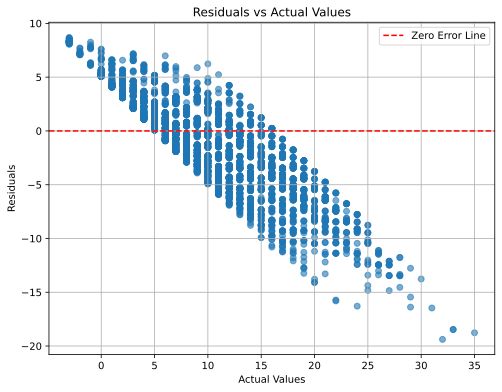

In [115]:
# Calculate residuals
residuals = test_predictions - test_labelT.numpy()

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(test_labelT.numpy(), residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label="Zero Error Line")
plt.title('Residuals vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid()
plt.show()


In [116]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate MSE and R2
mse = mean_squared_error(test_labelT.numpy(), test_predictions)
r2 = r2_score(test_labelT.numpy(), test_predictions)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'R-squared (R²): {r2:.4f}')

from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(test_labelT.numpy(), test_predictions))
rmse



Mean Squared Error (MSE): 20.2725
R-squared (R²): 0.4463


4.5025034

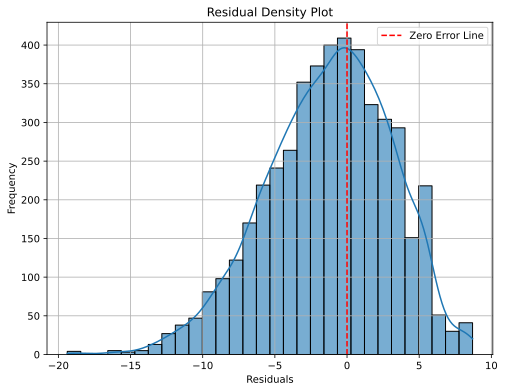

In [117]:
import seaborn as sns

# Plot density of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue', alpha=0.6)
plt.axvline(0, color='red', linestyle='--', label="Zero Error Line")
plt.title('Residual Density Plot')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()
